In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "5"  # adjust for your machine and availability
import jax

os.listdir()
# os.chdir("..")
from src.c3po.model.model import C3PO
from src.c3po.toy_model_generators.hmm import generate_hmm_spike_train
from src.c3po.toy_model_generators.phase import generate_periodic_spike_train

# Toy Model: Periodic Oscillator

In this example, we generate a collection of neurons, each with a template waveform.
When a neuron 'fires' we generate a waveform as the template overlaid with gaussian noise on each channel.

The firing rate of each neuron is modulated by an underlying periodic variable

The sampled data is collected through poisson sampling of the time-varying intensity function

In [ ]:
mark_ids, mark_times, marks, template_waveforms, tuning_curves = (
    generate_periodic_spike_train(
        latent_period=3,
        noise_scale=0.1,
        t_max=1000,
        n_units=64,
        n_channels=128,
        max_wait_update=0.3,
    )
)

# Build Model

In [ ]:
# prep data for model
from src.c3po.model.util import prep_training_data

delta_t = np.diff(mark_times)[None, ...]
x = marks[1:][None, ...]

sample_length = 2000
x_train, delta_t_train = prep_training_data(x, delta_t, sample_length)
i = sample_length

# hyperparams
latent_dim = 3
context_dim = 3
encoder_widths = [64, 32, 16, 8]

n_neg_samples = 32
encoder_args = dict(encoder_model="simple", widths=encoder_widths)
dilations = [
    1,
    2,
    4,
    8,
]
kernels = [8, 8, 16, 16]
# dilations = dilations * 2
# kernels = kernels * 2
context_args = dict(
    context_model="wavenet",
    layer_dilations=dilations,
    layer_kernel_size=kernels,
    expanded_dim=64,
    smoothing=2,
    smoothing_decay=1,
    categorical=False,
)


rate_args = dict(
    rate_model="bilinear",
)


# model = C3PO(encoder_args, context_args, rate_args, latent_dim, context_dim, n_neg_samples)
model = C3PO(
    encoder_args,
    context_args,
    rate_args,
    distribution="poisson",
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=1,
    return_embeddings_in_call=True,
)

rand_key = jax.random.PRNGKey(0)
params = model.init(jax.random.PRNGKey(0), x, delta_t, rand_key)
run_model = jax.jit(model.apply)
x_train.shape

z_stacked (1, 1, 49327, 3)
Z (1, 49328, 3) pos_params (1, 1, 49327, 1)
neg_z (1, 32, 49328, 3)
c (1, 49328, 3)
neg_params (1, 32, 49327, 1)


(48, 2000, 128)

 # Train Model

In [94]:
import optax
from tqdm import tqdm
from src.c3po.model.model import loss

learning_rate = 1e-3
batch_size = 64


def training_loss_fun(params, x, delta_t, rand_key):
    pos_params, neg_params, z, c, neg_z = run_model(params, x, delta_t, rand_key)
    return model.contrastive_loss(
        pos_params,
        neg_params,
        delta_t,
        z[:, 1:],
        neg_z,
    )


loss_grad_fn = jax.value_and_grad(training_loss_fun)


optimizer = optax.chain(
    # optax.clip_by_global_norm(1.0),
    optax.adam(learning_rate),
)

# Initialize parameters of the model + optimizer.
opt_state = optimizer.init(params)
# Run training loop.
tracked_loss = []
with tqdm() as pbar:
    for i in range(1000):
        ind = np.arange(x_train.shape[0])
        np.random.shuffle(ind)
        epoch_loss = []
        j = 0
        while j < x_train.shape[0]:
            # Perform one gradient update.
            rand_key, _ = jax.random.split(rand_key)
            batch_inds = ind[j : j + batch_size]
            loss_val, grads = loss_grad_fn(
                params, x_train[batch_inds], delta_t_train[batch_inds], rand_key
            )
            epoch_loss.append(loss_val)
            updates, opt_state = optimizer.update(grads, opt_state)
            params = optax.apply_updates(params, updates)
            j += batch_size
        tracked_loss.append(np.mean(epoch_loss))
        pbar.update(1)
        pbar.set_description(f"loss: {tracked_loss[-1]:.4f}")

0it [00:00, ?it/s]

z_stacked (48, 1, 1999, 3)
Z (48, 2000, 3) pos_params (48, 1, 1999, 1)
neg_z (48, 32, 2000, 3)
c (48, 2000, 3)
neg_params (48, 32, 1999, 1)


loss: 2.1435: : 1000it [04:04,  4.10it/s]


Text(0, 0.5, 'Loss')

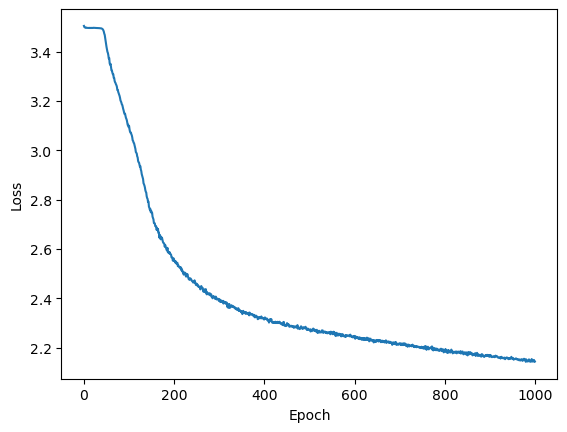

In [95]:
epoch = np.arange(len(tracked_loss))
plt.plot(epoch, tracked_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Analyze Results

In [ ]:
from src.c3po.analysis.analysis import C3poAnalysis

model_args = dict(
    encoder_args=encoder_args,
    context_args=context_args,
    rate_args=rate_args,
    distribution="poisson",
    latent_dim=latent_dim,
    context_dim=context_dim,
    n_neg_samples=n_neg_samples,
    predicted_sequence_length=1,
    sample_params=None,
)
analysis = C3poAnalysis(
    model=model,
    model_args=model_args,
    params=params,
)

In [97]:
analysis.embed_data(x, delta_t, first_mark_time=0, chunk_size=5000, delta_t_units="s")
analysis.fit_context_pca()
t_interp = np.arange(analysis.t[0], analysis.t[-1], 0.001)
analysis.interpolate_context(t_interp)
analysis.embed_context_pca()

 91%|█████████ | 45000/49328 [00:00<00:00, 57835.75it/s]


### Example trace

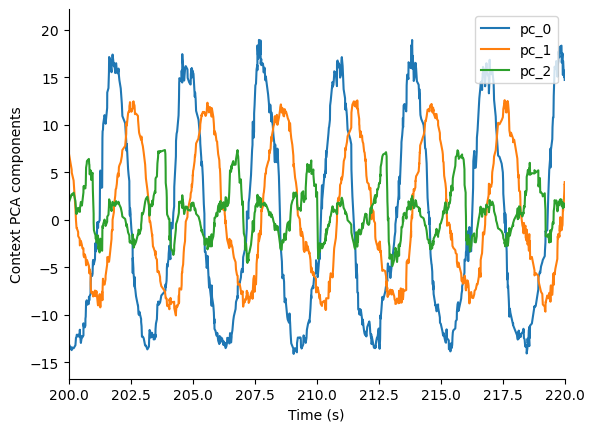

In [ ]:
# example context trace
for i in range(context_dim):
    plt.plot(
        analysis.t,
        analysis.c_pca[:, i],
        label=f"pc_{i}",
    )
plt.legend(loc=1)
plt.xlabel("Time (s)")
plt.ylabel("Context PCA components")
plt.xlim(200, 220)
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)

### Context-phase relationship

Text(0.5, 0, 'Latent phase (rad)')

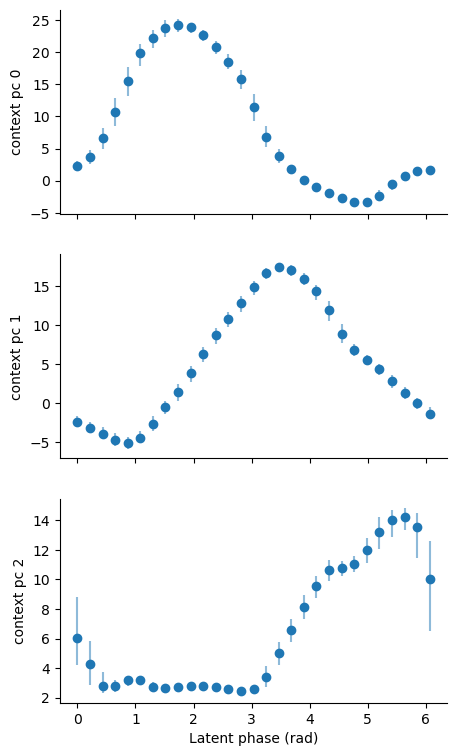

In [129]:
c_binned, bins = analysis.bin_context_by_feature(theta, t)

fig, ax = plt.subplots(
    nrows=context_dim, ncols=1, figsize=(5, 3 * context_dim), sharex=True
)

for i in range(context_dim):
    ax[i].scatter(bins[:-1], [np.median(cc[:, i]) for cc in c_binned])
    lo = [np.percentile(cc[:, i], 25) for cc in c_binned]
    hi = [np.percentile(cc[:, i], 75) for cc in c_binned]
    ax[i].vlines(bins[:-1], lo, hi, color="C0", alpha=0.5)
    ax[i].set_ylabel(f"context pc {i}")
    ax[i].spines[["top", "right"]].set_visible(False)

plt.xlabel("Latent phase (rad)")

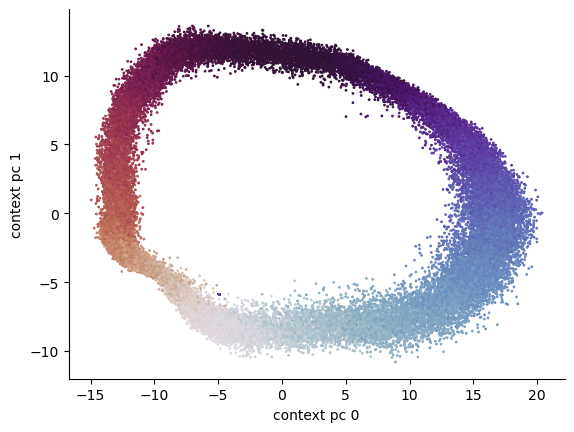

In [ ]:
# Context embedding
mark_phase_ind = np.digitize(analysis.t, t)
mark_phase = theta[mark_phase_ind]
plt.scatter(
    analysis.c_pca[:, 0], analysis.c_pca[:, 1], c=mark_phase, s=1, cmap="twilight"
)
plt.xlabel("context pc 0")
plt.ylabel("context pc 1")
ax = plt.gca()
ax.spines[["top", "right"]].set_visible(False)

### Waveform embedding (Codes for tuning information, NOT waveform voltages)

Text(0.5, 1.0, 'Waveform Embedding NOT organized by waveform shape')

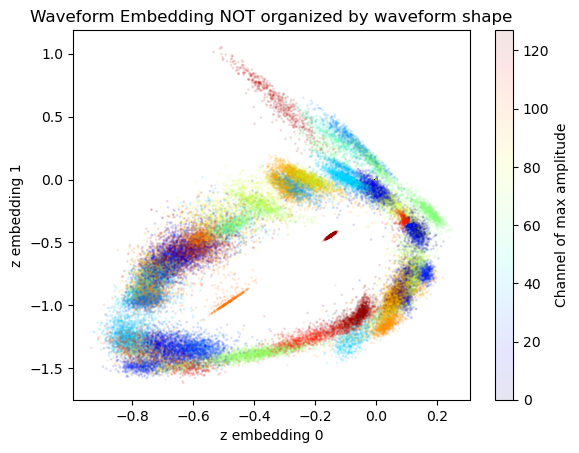

In [156]:
z = analysis.z
ids = mark_ids[1:]
feature = template_waveforms[ids].argmax(axis=1)
plt.scatter(z[:, 0], z[:, 1], s=1, alpha=0.1, c=feature, cmap="jet")
plt.colorbar(label="Channel of max amplitude")
plt.xlabel("z embedding 0")
plt.ylabel("z embedding 1")

plt.title("Waveform Embedding NOT organized by waveform shape")

Text(0.5, 1.0, 'Waveform Embedding IS organized by tuning features')

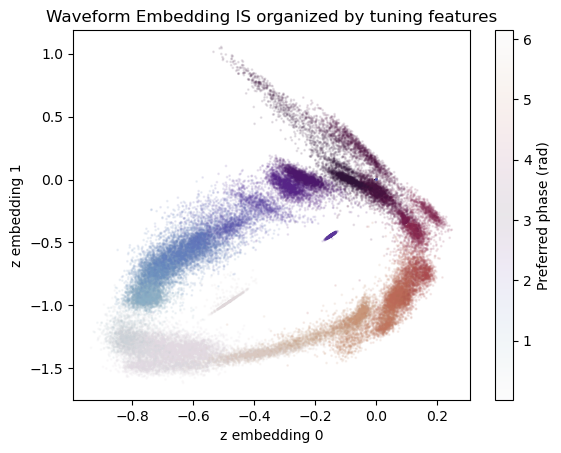

In [158]:
ids = mark_ids[1:]
feature = tuning_curves["theta_max"][ids]
plt.scatter(z[:, 0], z[:, 1], s=1, alpha=0.1, c=feature, cmap="twilight")
plt.colorbar(label="Preferred phase (rad)")
plt.xlabel("z embedding 0")
plt.ylabel("z embedding 1")

plt.title("Waveform Embedding IS organized by tuning features")

### FIgure demonstrating information bottleneck

In [ ]:
i = 19  # example neuron

# Find neuron with similar tuning curve
peak = tuning_curves["theta_max"][i]
target_peak = peak + 0.5
i_tuning = np.argmin((tuning_curves["theta_max"] - target_peak) ** 2)

# Find neuron with similar waveform
peak = np.argmax(template_waveforms[i])
target_peak = peak + 10
i_waveform = np.argmin((template_waveforms.argmax(axis=1) - target_peak) ** 2)

samples = [i, i_tuning, i_waveform]

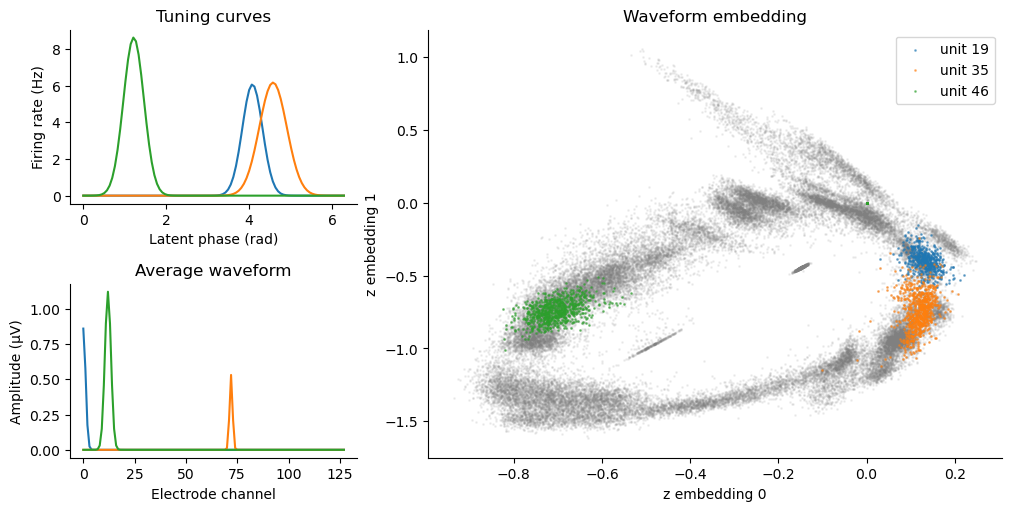

In [ ]:
from matplotlib.gridspec import GridSpec
from src.c3po.toy_model_generators.phase import gaussian

fig = plt.figure(constrained_layout=True, figsize=(10, 5))
gs = GridSpec(2, 3, figure=fig)
tuning_ax = fig.add_subplot(gs[0, 0])
waveform_ax = fig.add_subplot(gs[1, 0])
embedding_ax = fig.add_subplot(gs[:, 1:])

for i_ in samples:
    theta_bins = np.linspace(0, 2 * np.pi, 100)
    tuning_curve_i = (
        gaussian(theta_bins, tuning_curves["theta_max"][i_], tuning_curves["sigma"][i_])
        * tuning_curves["amplitude"][i_]
    )
    tuning_ax.plot(theta_bins, tuning_curve_i)

    waveform_ax.plot(
        template_waveforms[i_].T,
    )

z = analysis.z
ids = mark_ids[1:]
embedding_ax.scatter(z[:, 0], z[:, 1], s=1, alpha=0.1, c="grey")
for i_, c_ in zip(samples, ["C0", "C1", "C2"]):
    embedding_ax.scatter(
        z[ids == i_, 0], z[ids == i_, 1], s=1, alpha=0.5, c=c_, label=f"unit {i_}"
    )

tuning_ax.set_xlabel("Latent phase (rad)")
tuning_ax.set_ylabel("Firing rate (Hz)")
tuning_ax.spines[["top", "right"]].set_visible(False)
tuning_ax.set_title("Tuning curves")

waveform_ax.set_xlabel("Electrode channel")
waveform_ax.set_ylabel("Amplitude (µV)")
waveform_ax.spines[["top", "right"]].set_visible(False)
waveform_ax.set_title("Average waveform")

embedding_ax.set_xlabel("z embedding 0")
embedding_ax.set_ylabel("z embedding 1")
embedding_ax.spines[["top", "right"]].set_visible(False)
embedding_ax.set_title("Waveform embedding")
embedding_ax.legend(loc=1)